Solver for the semi-discrete 1D avection problem:

In [33]:
import numpy as np
from scipy.linalg import circulant
from scipy.integrate import solve_ivp

# Operator from HW1
def D_operator_periodic(N,L,R,a):
    first_row = np.zeros(N); first_row[0:L+R+1] = a; first_row = np.roll(first_row,-L)
    return np.array(circulant(first_row)).transpose()

# Functor for the 1D advection equation
def LinearAdv1D(t,U,D):
    # Initialize velocity
    a = 1
    # Return F(t,U)
    return (-a*D)@U

# General integrator function
def Integrator(periodic,operator,problem,L,T,Nx,Nt,U0):
    ######################## Inputs of the function "Integrator" ##########################
    #                                                                                     #
    # periodic : boolean flag to select periodicity (options: True of False)              #
    # operator : string to select the spatial derivative operator                         #
    #  problem : string to select the governing equations                                 # 
    #        L : length of the physical domain, x runs from 0 to L                        #
    #        T : length of the temporal domain, t runs from 0 to T                        #
    #       Nx : number of points to use in x                                             #
    #       Nt : number of points to use in t (for reporting the solutions)               #
    #       U0 : initial condition                                                        #
    #                                                                                     #
    ######################## Outputs of the function "Integrator" #########################
    #                                                                                     #
    #        t : the discrete time levels (in a vector of size Nt)                        #
    #        U : the solutions (in a matrix of size Nt x Nx)                              #
    #                                                                                     #
    #######################################################################################

    # Initialize spatial domain
    x  = np.linspace(0, L, Nx, endpoint=(not periodic))
    dx = x[1] - x[0]

    # Initialize temporal domain
    t  = np.linspace(0, T, Nt, endpoint=True)

    # Construct spatial matrix operator
    match (operator,periodic):
        case ('1st-order upwind',True):       # Periodic 1st-order upwind
            D = D_operator_periodic(Nx,1,0,[-1/dx,1/dx])
        case ('2nd-order central',True):      # Periodic 2nd-order central differences
            D = D_operator_periodic(Nx,1,1,[-1/(2*dx),0,1/(2*dx)])
        case ('3rd-order upwind',True):       # Periodic 3rd-order upwind
            D = D_operator_periodic(Nx,2,1,[1/(6*dx),-1/dx,1/(2*dx),1/(3*dx)])
        case ('4th-order central',True):      # Periodic 4th-order central differences
            D = D_operator_periodic(Nx,2,2,[1/(12*dx),-8/(12*dx),0,8/(12*dx),-1/(12*dx)])
        case ('6th-order Padé',True):         # Periodic 6th-order Padé
            DR = D_operator_periodic(Nx,2,2,[-1/(36*dx),-28/(36*dx),0,28/(36*dx),1/(36*dx)])
            DL = D_operator_periodic(Nx,1,1,[1/3,1,1/3])
            D = np.linalg.inv(DL)@DR
        case _:
            raise Exception("The %s operator '%s' is not yet implement!" % ('periodic' if periodic else 'non-periodic', operator))

    # Solve and return solutions!
    match problem:
        case 'LinearAdv1D':
            # Solve initial value problem; see documentation at:
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html
            sol = solve_ivp(LinearAdv1D, [0, T], U0, args=(D,), t_eval=t, rtol=1.0e-6, atol=1.0e-6)
            # Transpose solution vector so U has the format (Nt x Nx)
            U = sol.y.transpose()
            # Return outputs
            return t, U, D
        case _:
            raise Exception("The case '%s' is not yet implement!" % problem)

Problem 2:

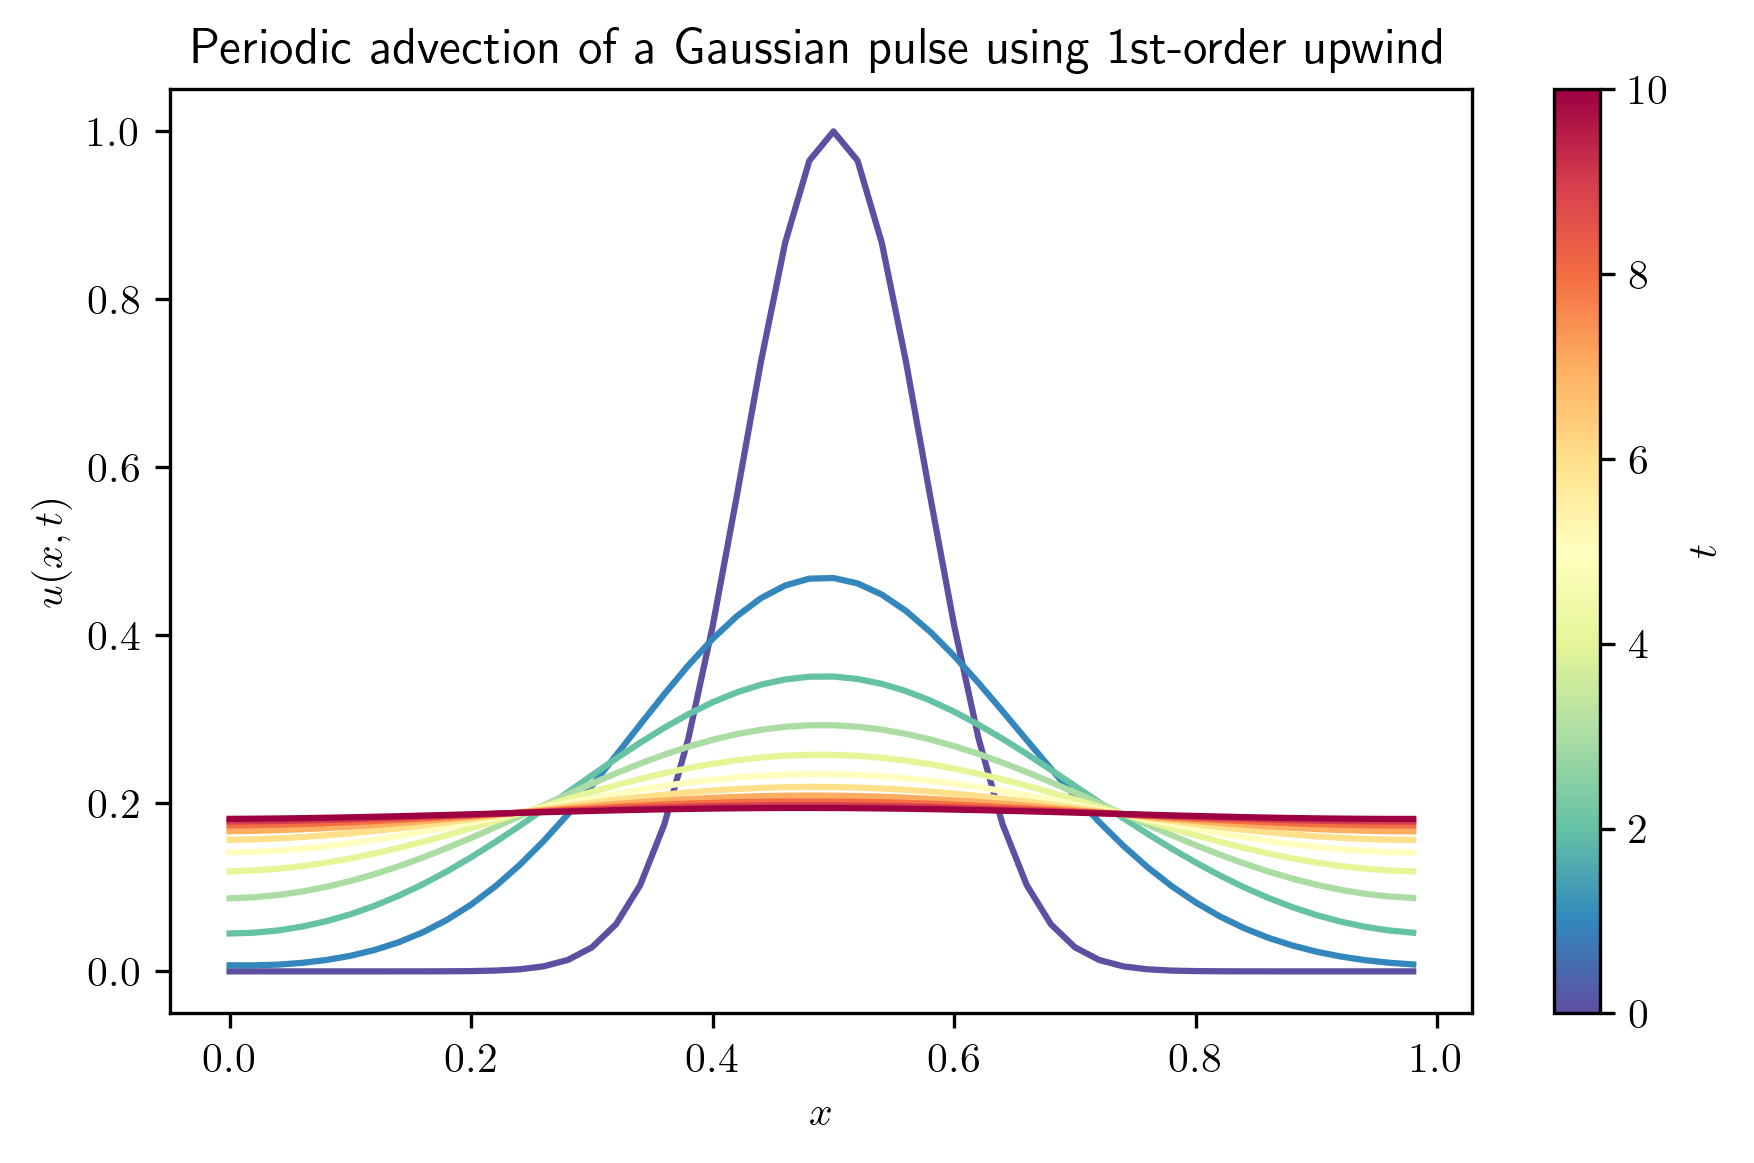

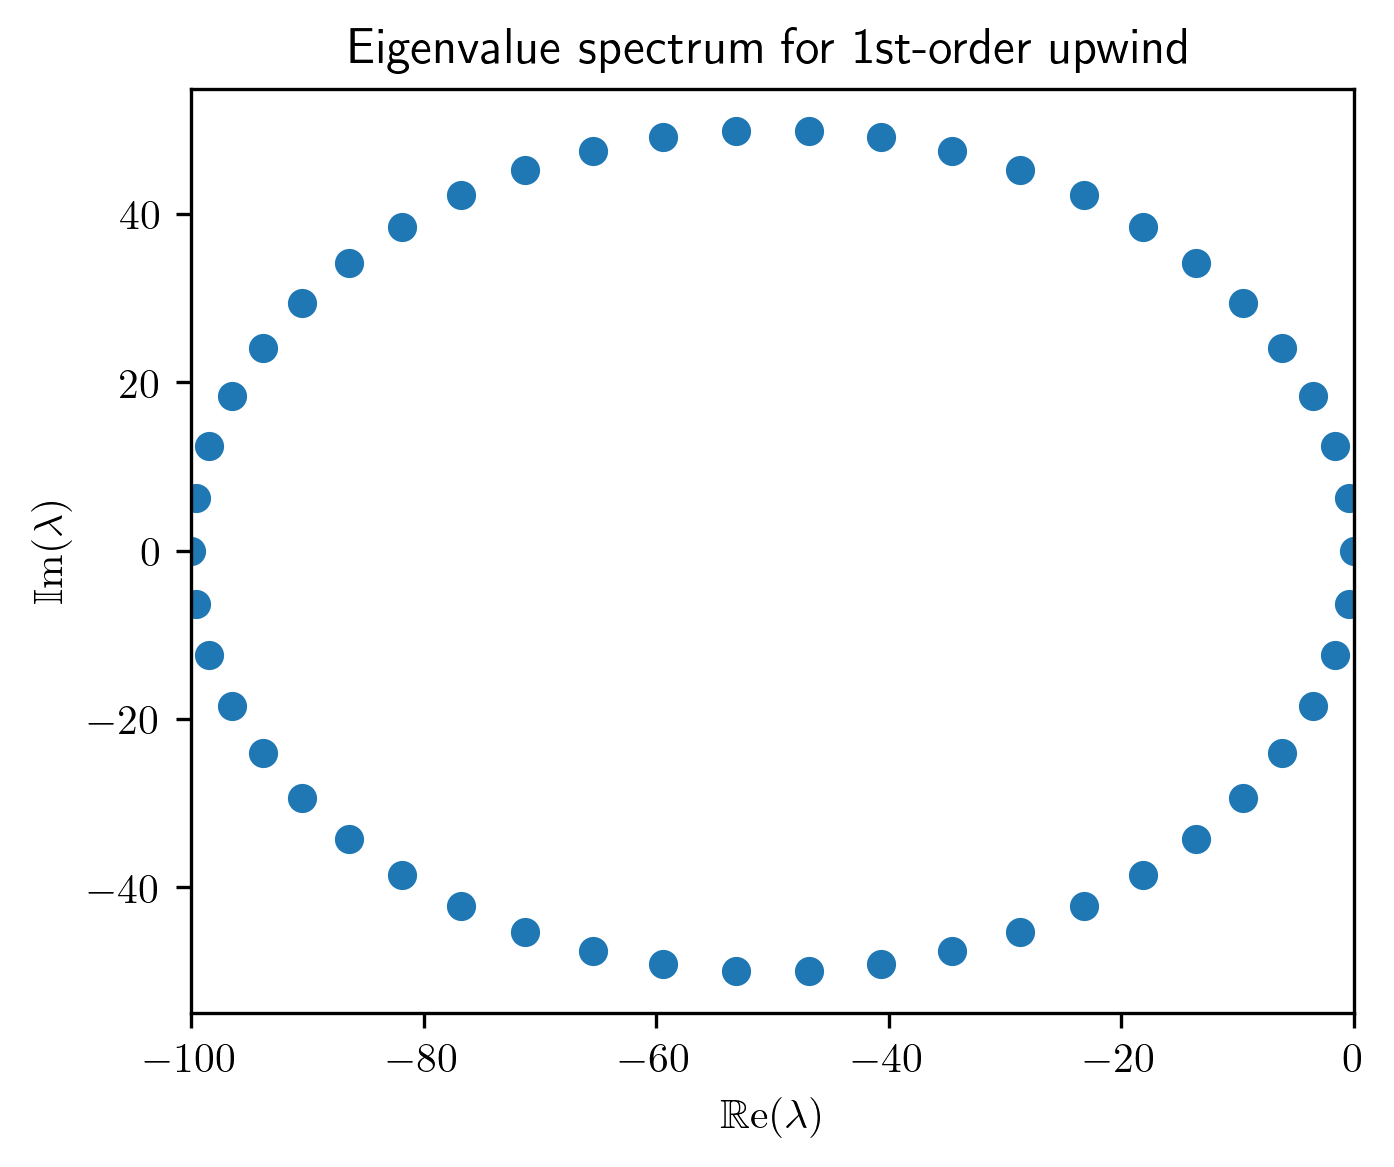

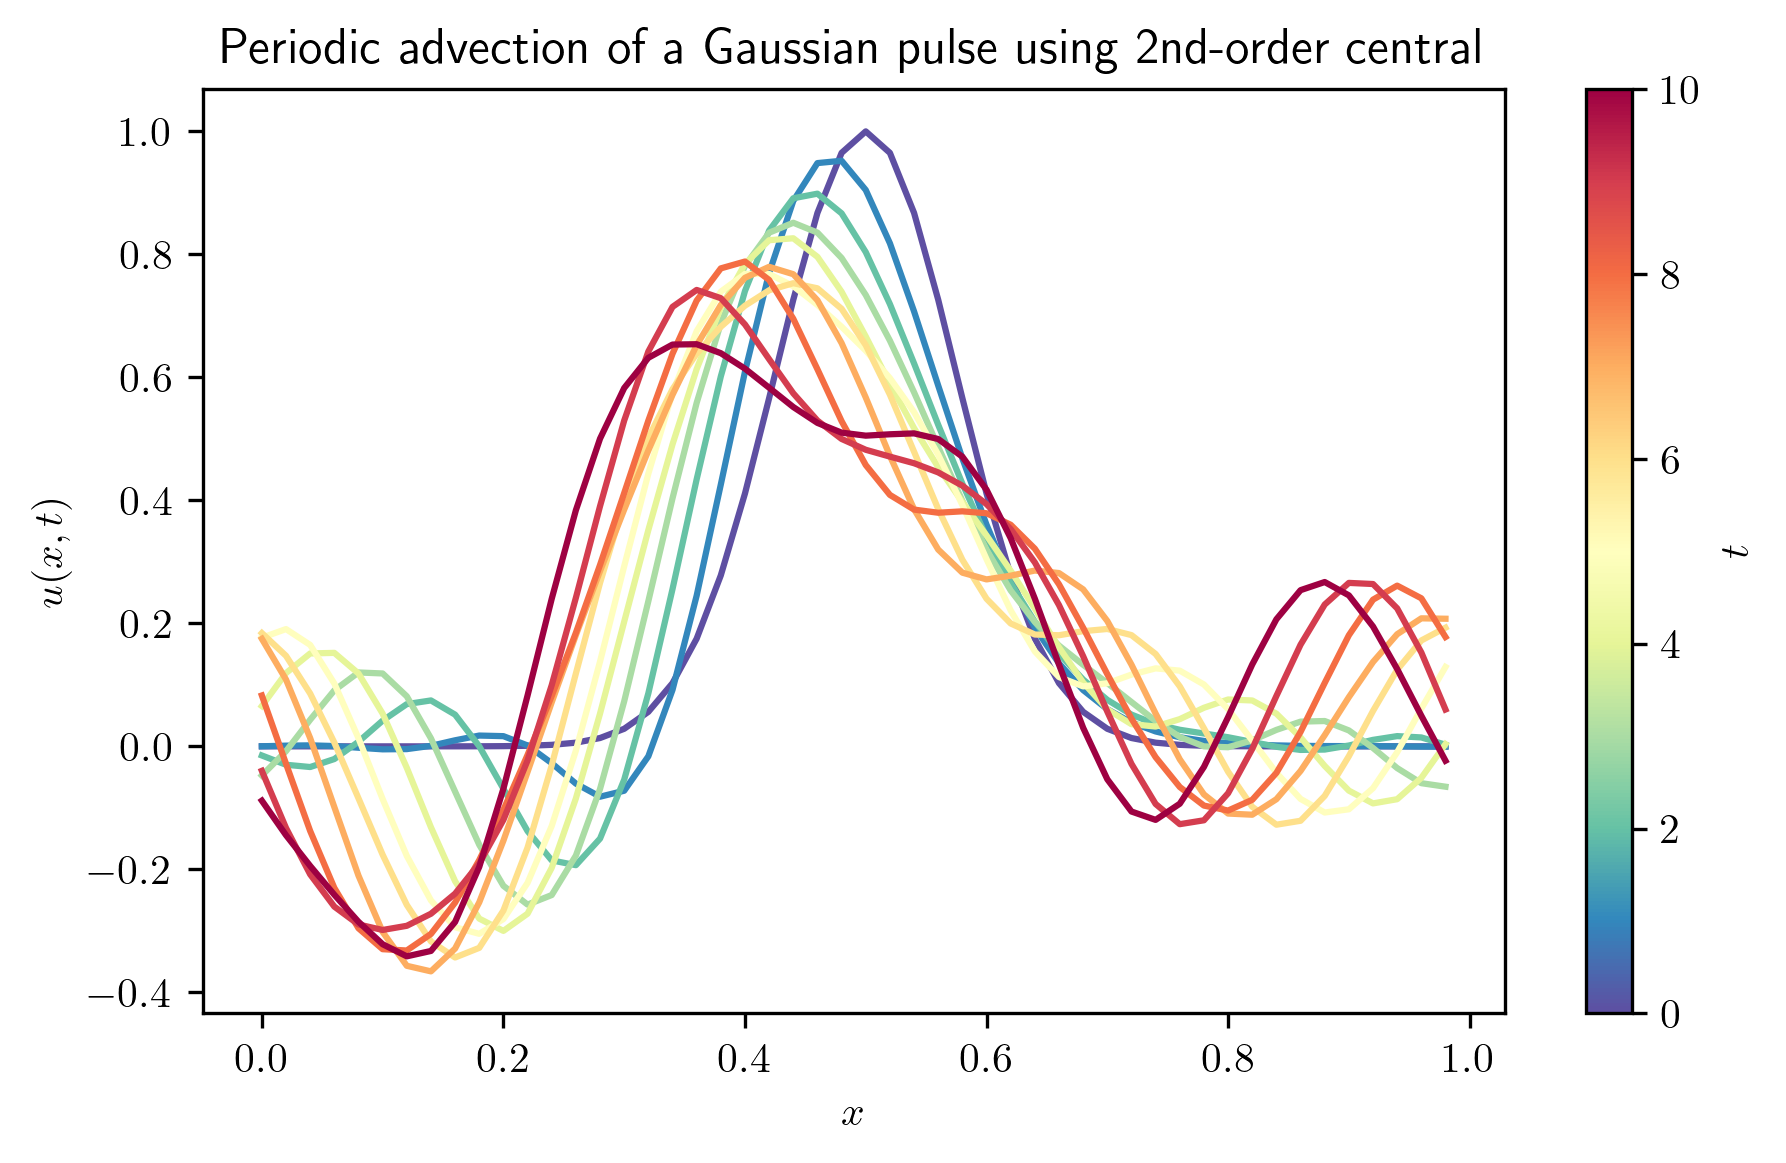

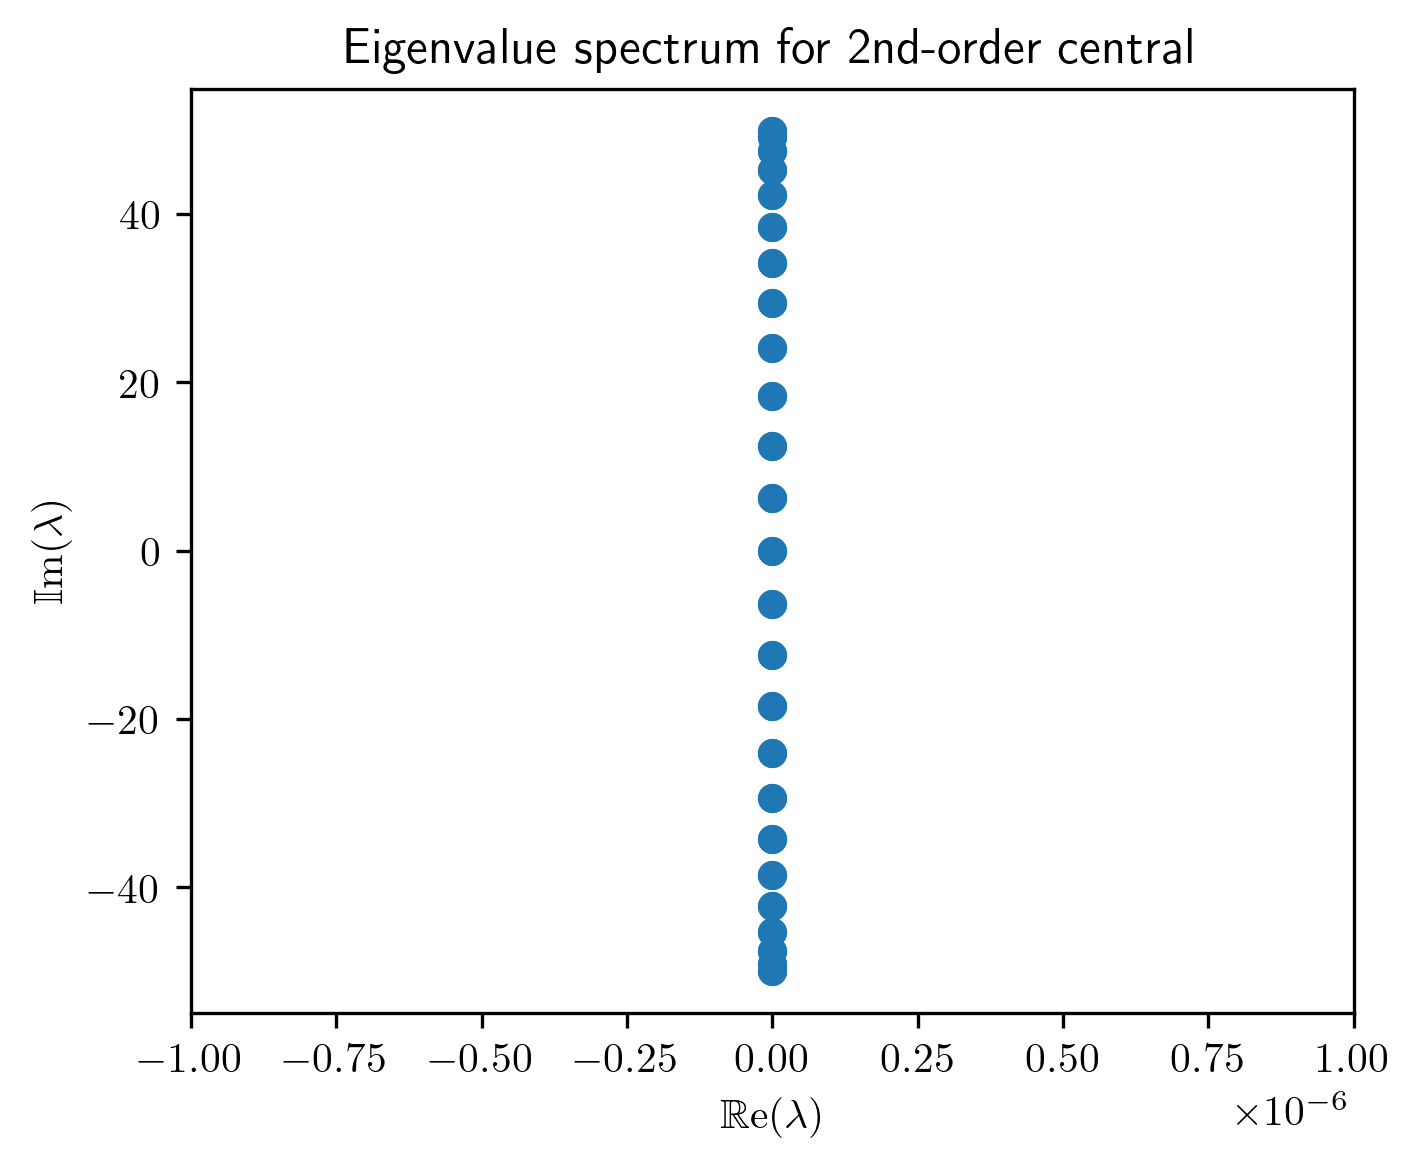

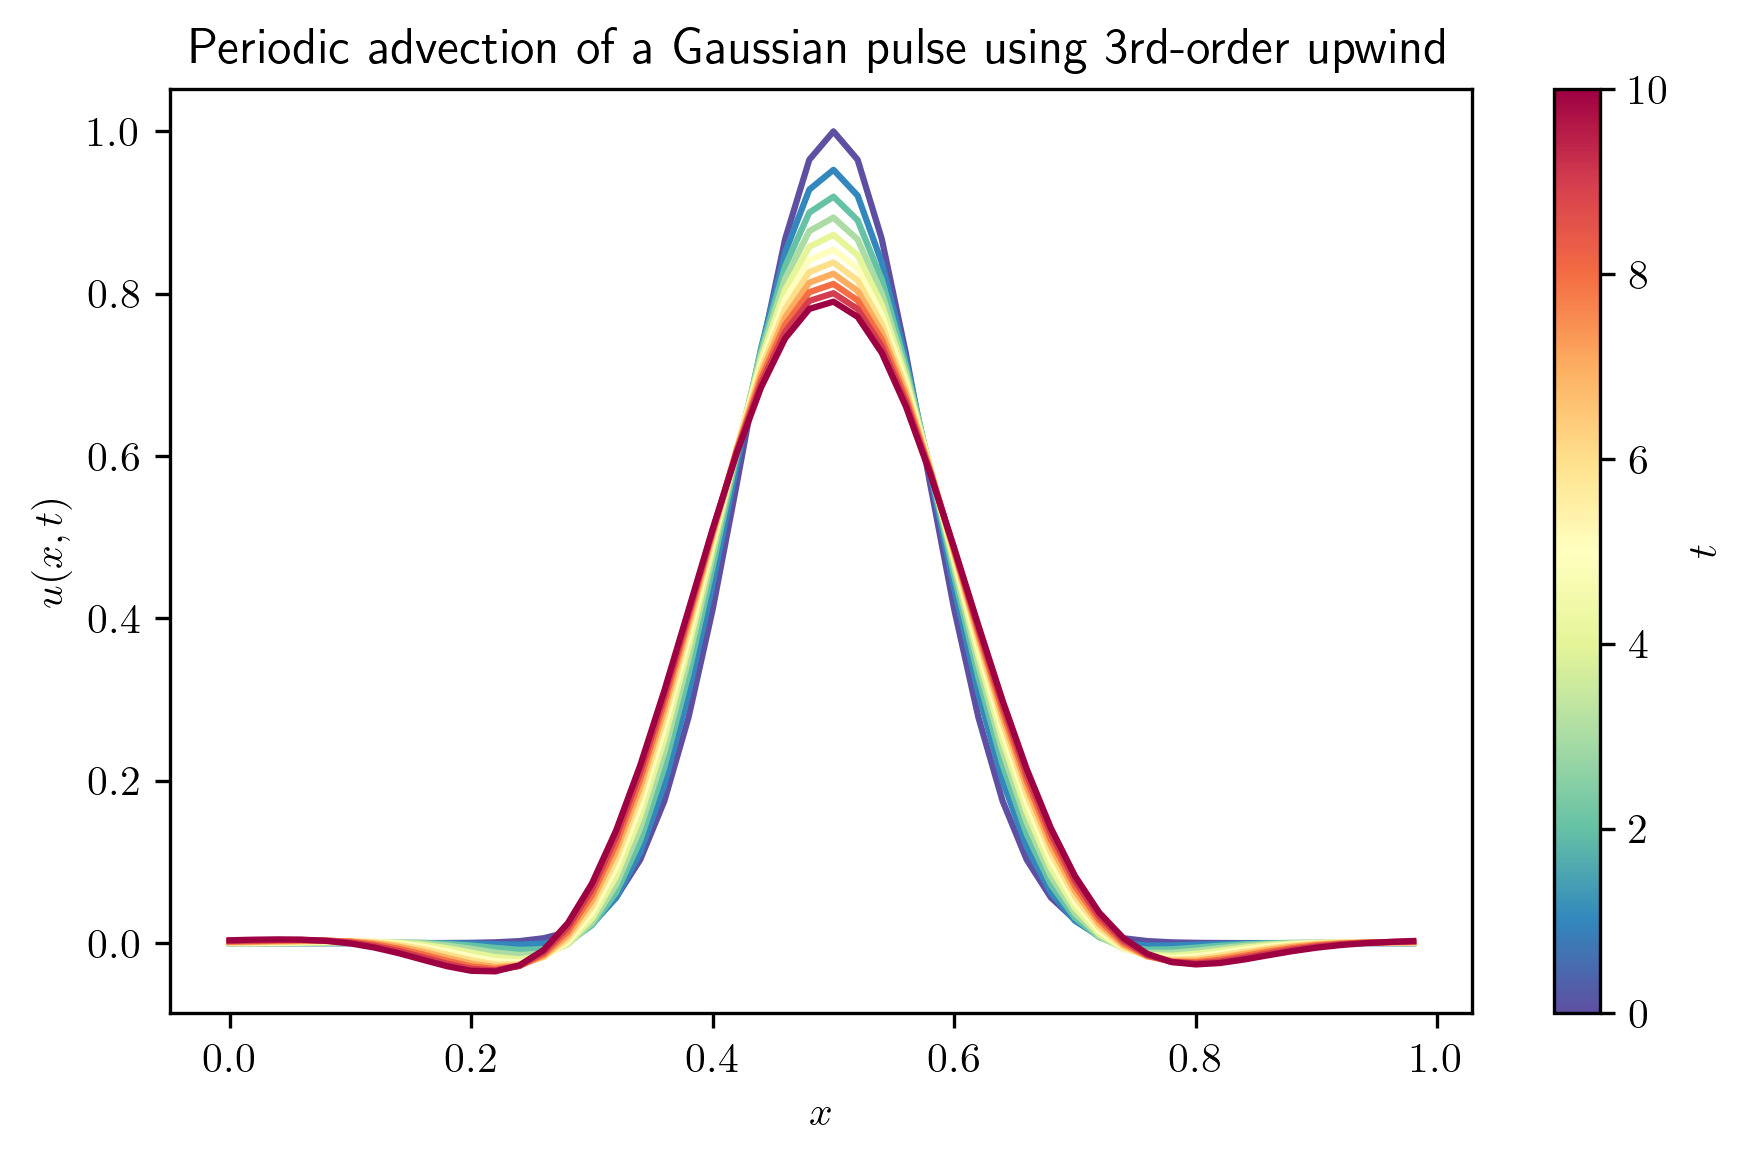

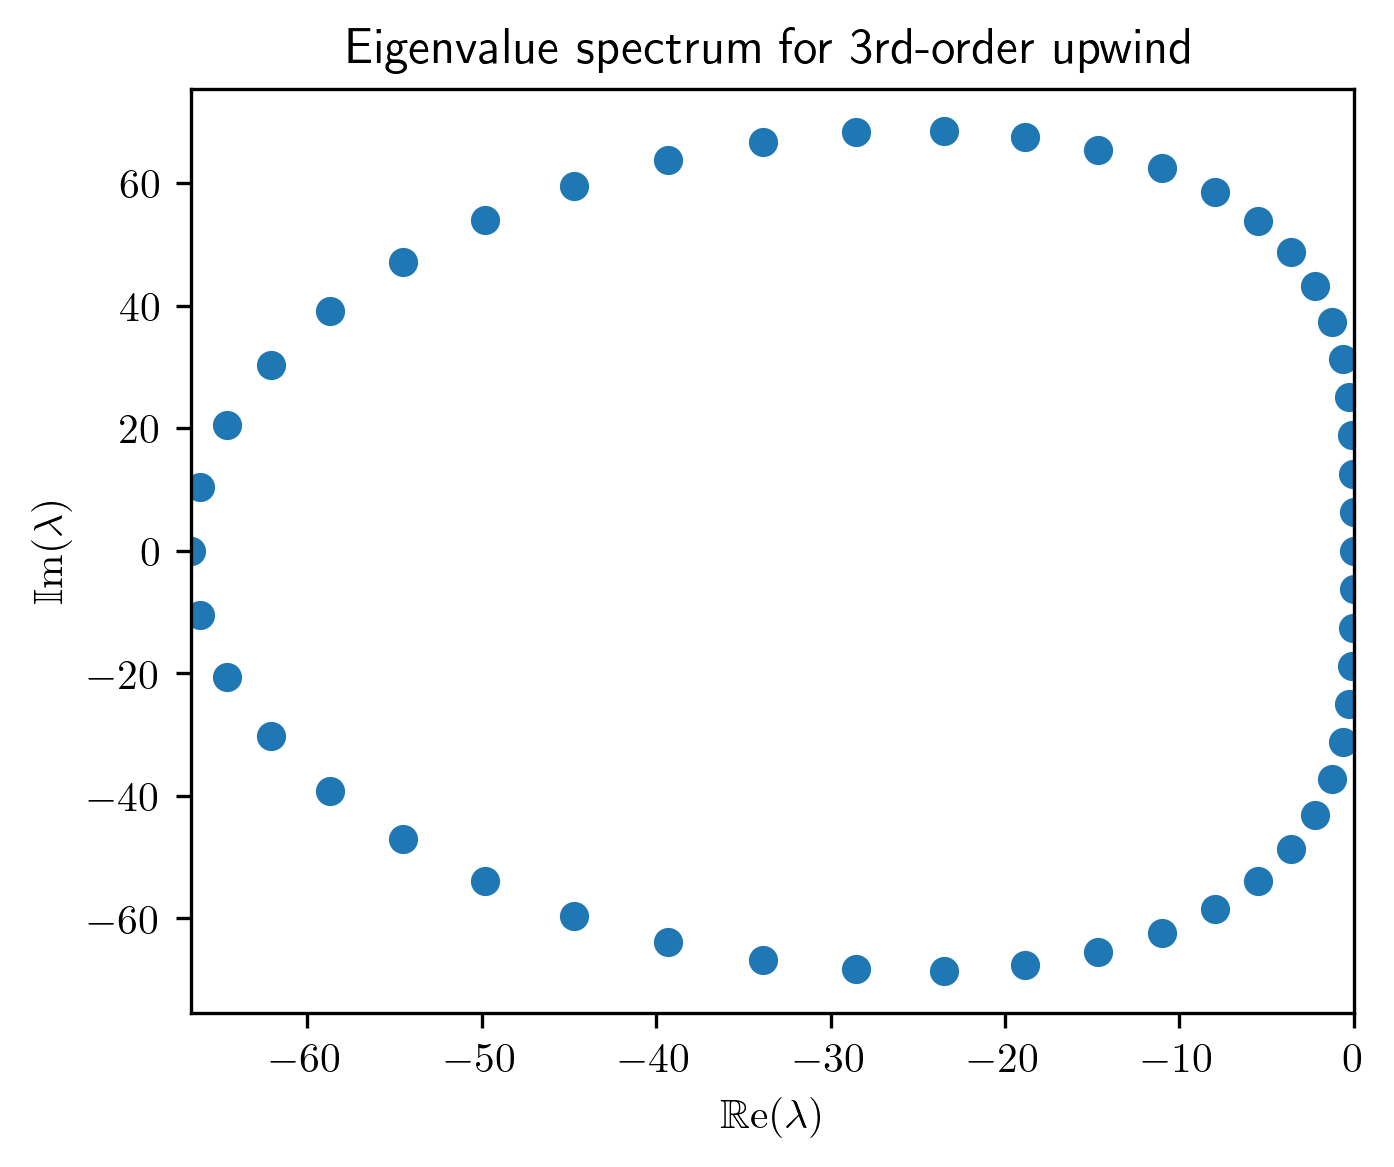

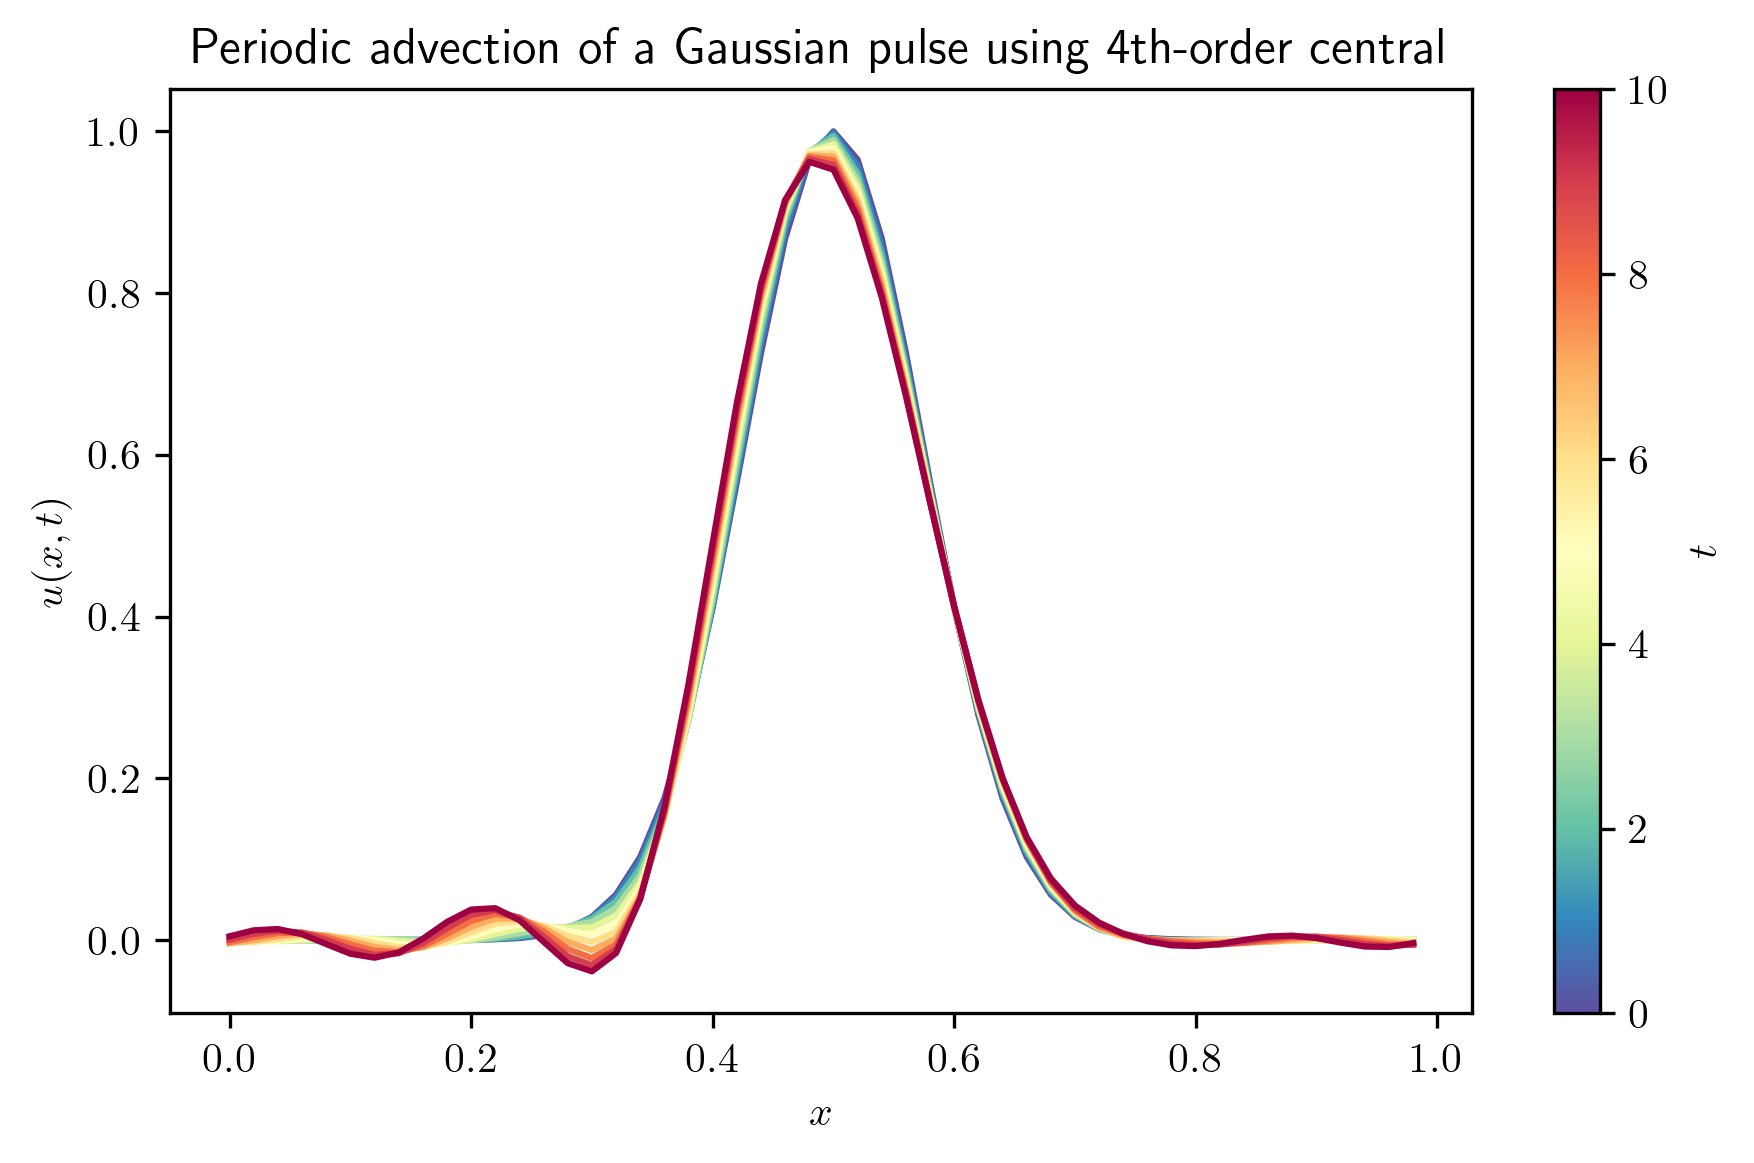

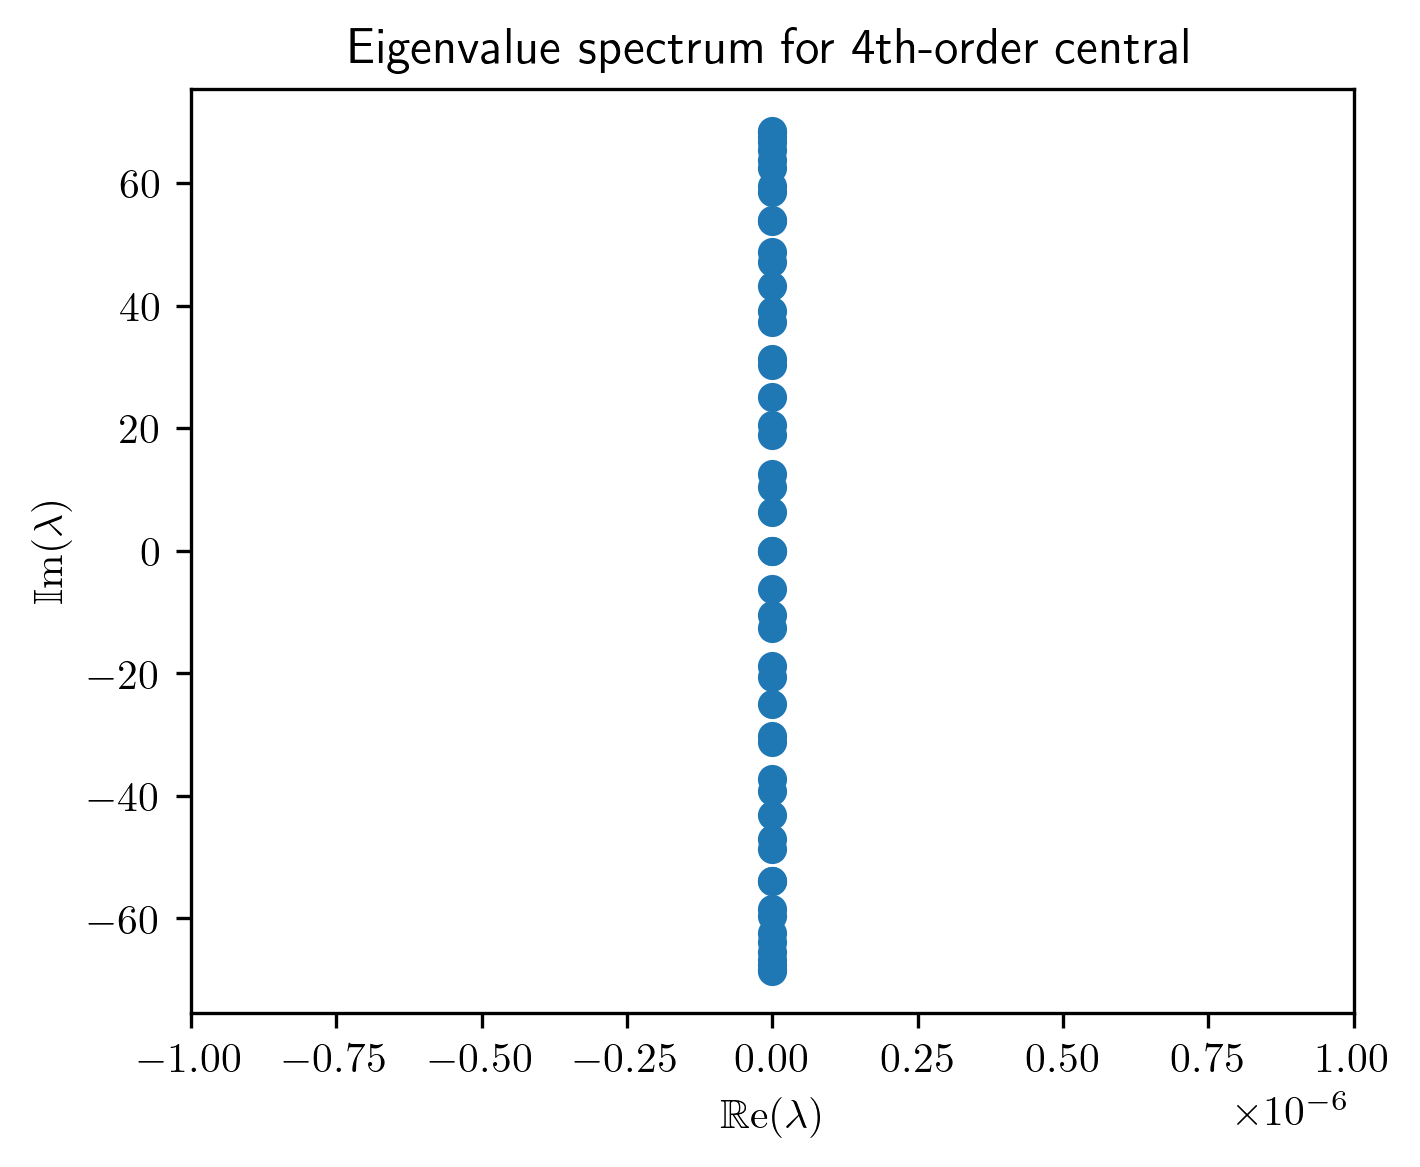

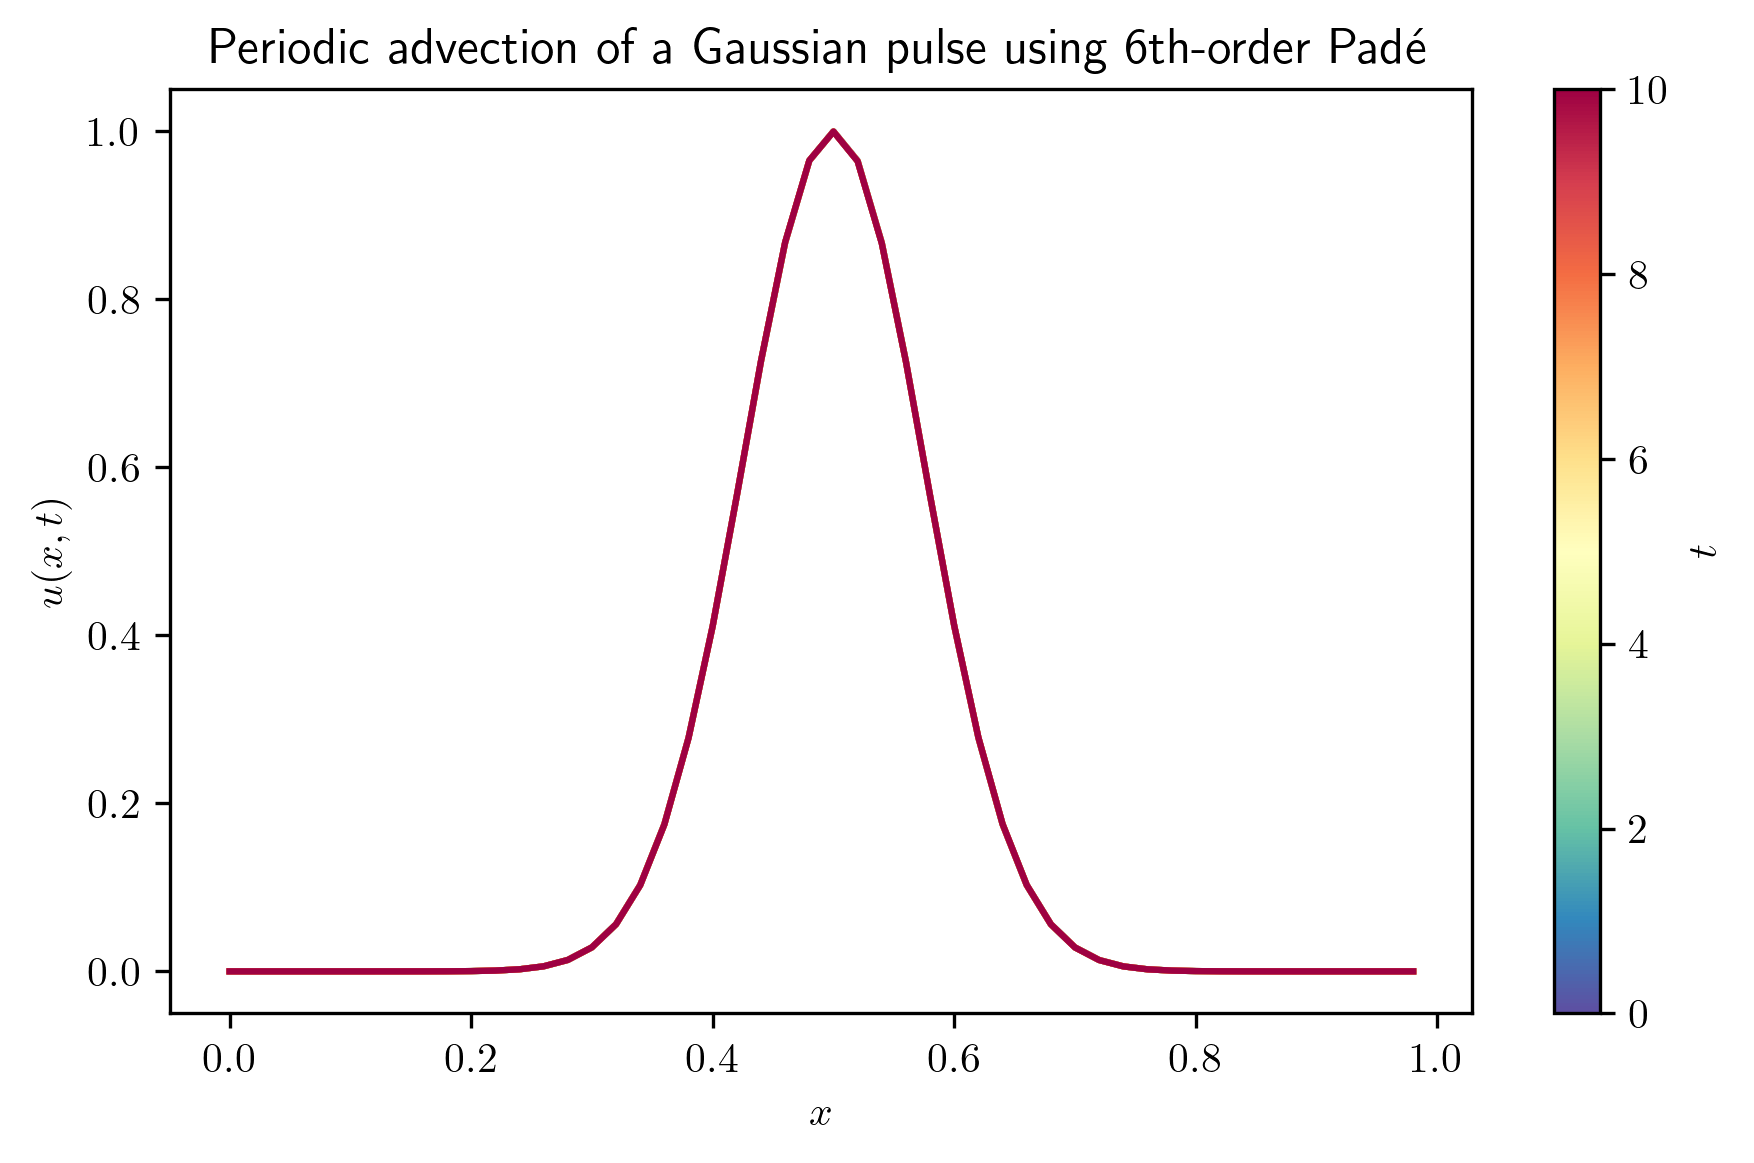

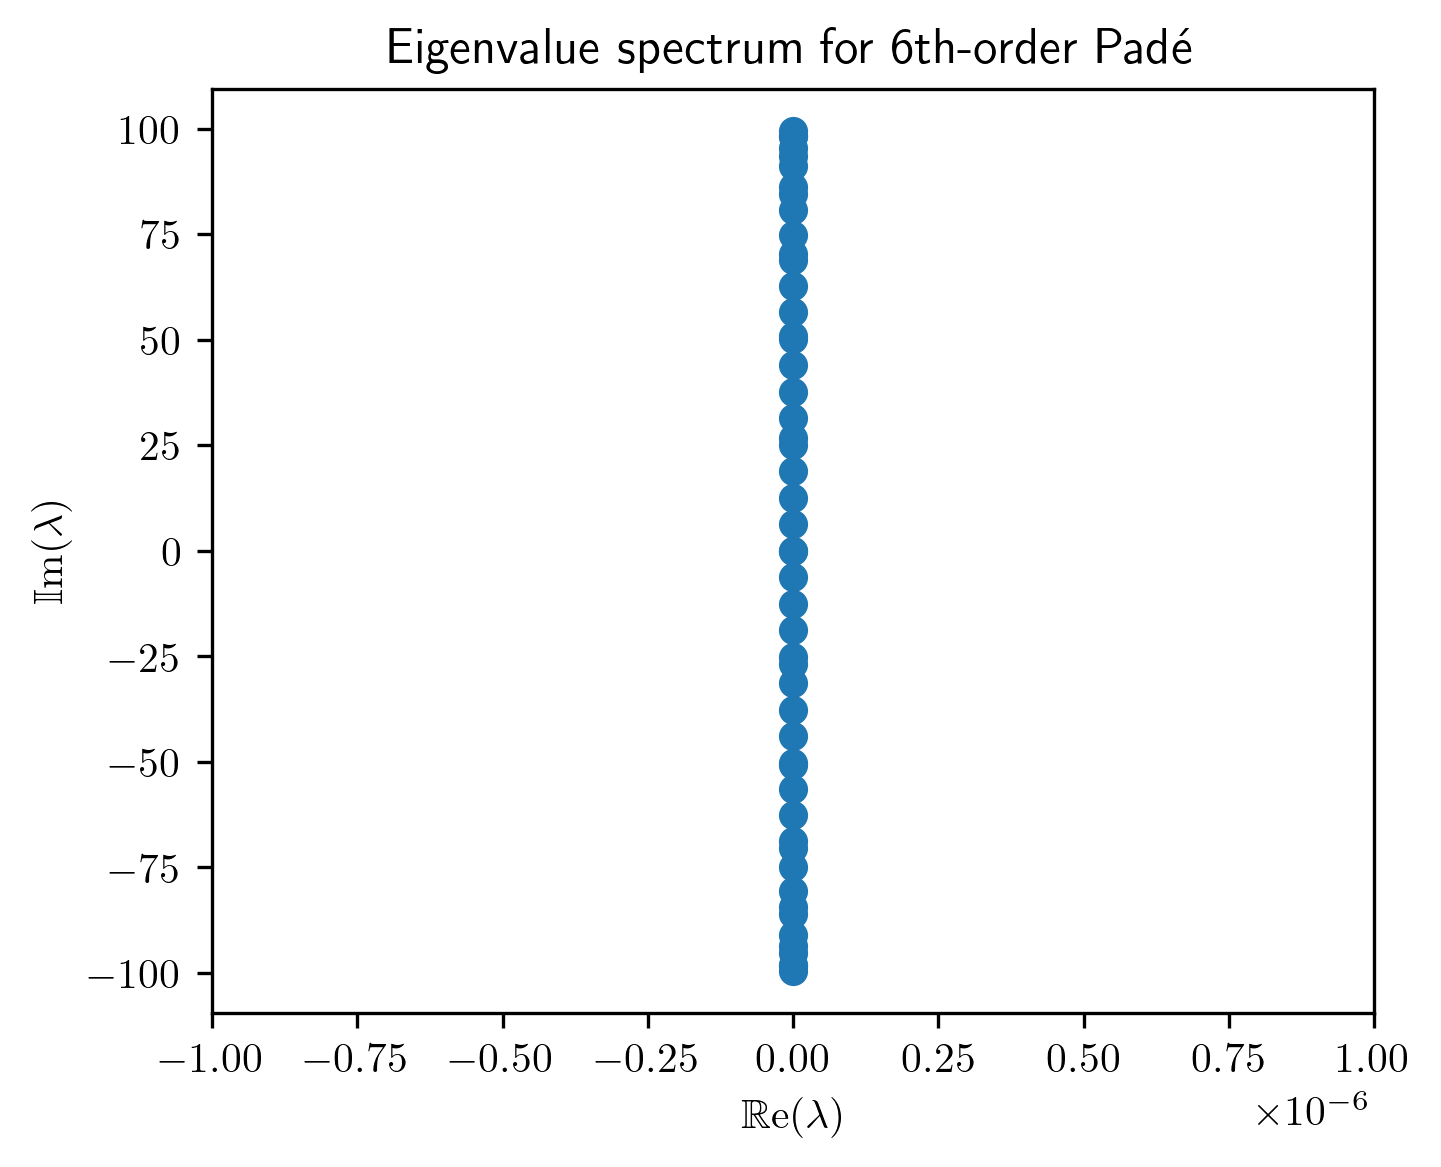

In [34]:
import matplotlib as mpl 
import matplotlib.pyplot as plt
from numpy import linalg as LA
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

# Initialize case parameters
L = 1; T = 10; Nx = 50; Nt = 11; a = 1
# Initialize solution at t=0
x = np.linspace(0, L, Nx, endpoint=False); dx = x[1] - x[0]
sigma = 3/40; U0 = np.exp(-(x-0.5)**2/(2*sigma**2))
# Initialize list of schemes that will be tested:
listofschemes = ['1st-order upwind', '2nd-order central', '3rd-order upwind', '4th-order central', '6th-order Padé']

# Plotting the eigenvalue spectra and numerical solutions for each scheme
A = []
for scheme in listofschemes: 
    # Run solver and plot solution
    t, U, D = Integrator(True, scheme, 'LinearAdv1D',L, T, Nx, Nt, U0)
    A.append(-a*D)
    fig, ax = plt.subplots(1, 1, figsize=(7, 4)) 
    ax.plot(x,U0,color=plt.cm.Spectral_r(0))
    for j in range(1,Nt):
        ax.plot(x,U[j],color=plt.cm.Spectral_r(t[j]/T))
    plt.title('Periodic advection of a Gaussian pulse using %s' % scheme)
    plt.xlabel(r'$x$');plt.ylabel(r'$u(x,t)$');
    fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(0, T), cmap='Spectral_r'),ax=ax, orientation='vertical', label=r'$t$')
    plt.savefig('solution-%s.pdf' % scheme)
    plt.show()

    # Plot eigenvalue spectrum
    fig, ax = plt.subplots(1, 1, figsize=(5, 4)) 
    eigenvalues, eigenvectors = LA.eig(-a*D)
    relambda = [ele.real for ele in eigenvalues] 
    imlambda = [ele.imag for ele in eigenvalues] 
    ax.scatter(relambda, imlambda) 
    plt.xlim(min(-1e-6,np.min(relambda)),max(1e-6,np.max(relambda)))
    plt.title('Eigenvalue spectrum for %s' % scheme)
    plt.xlabel(r'$\mathbb{R}\mathrm{e}(\lambda)$');plt.ylabel(r'$\mathbb{I}\mathrm{m}(\lambda)$');
    plt.savefig('eigenvalues-%s.pdf' % scheme)
    plt.show()

Problem 3:

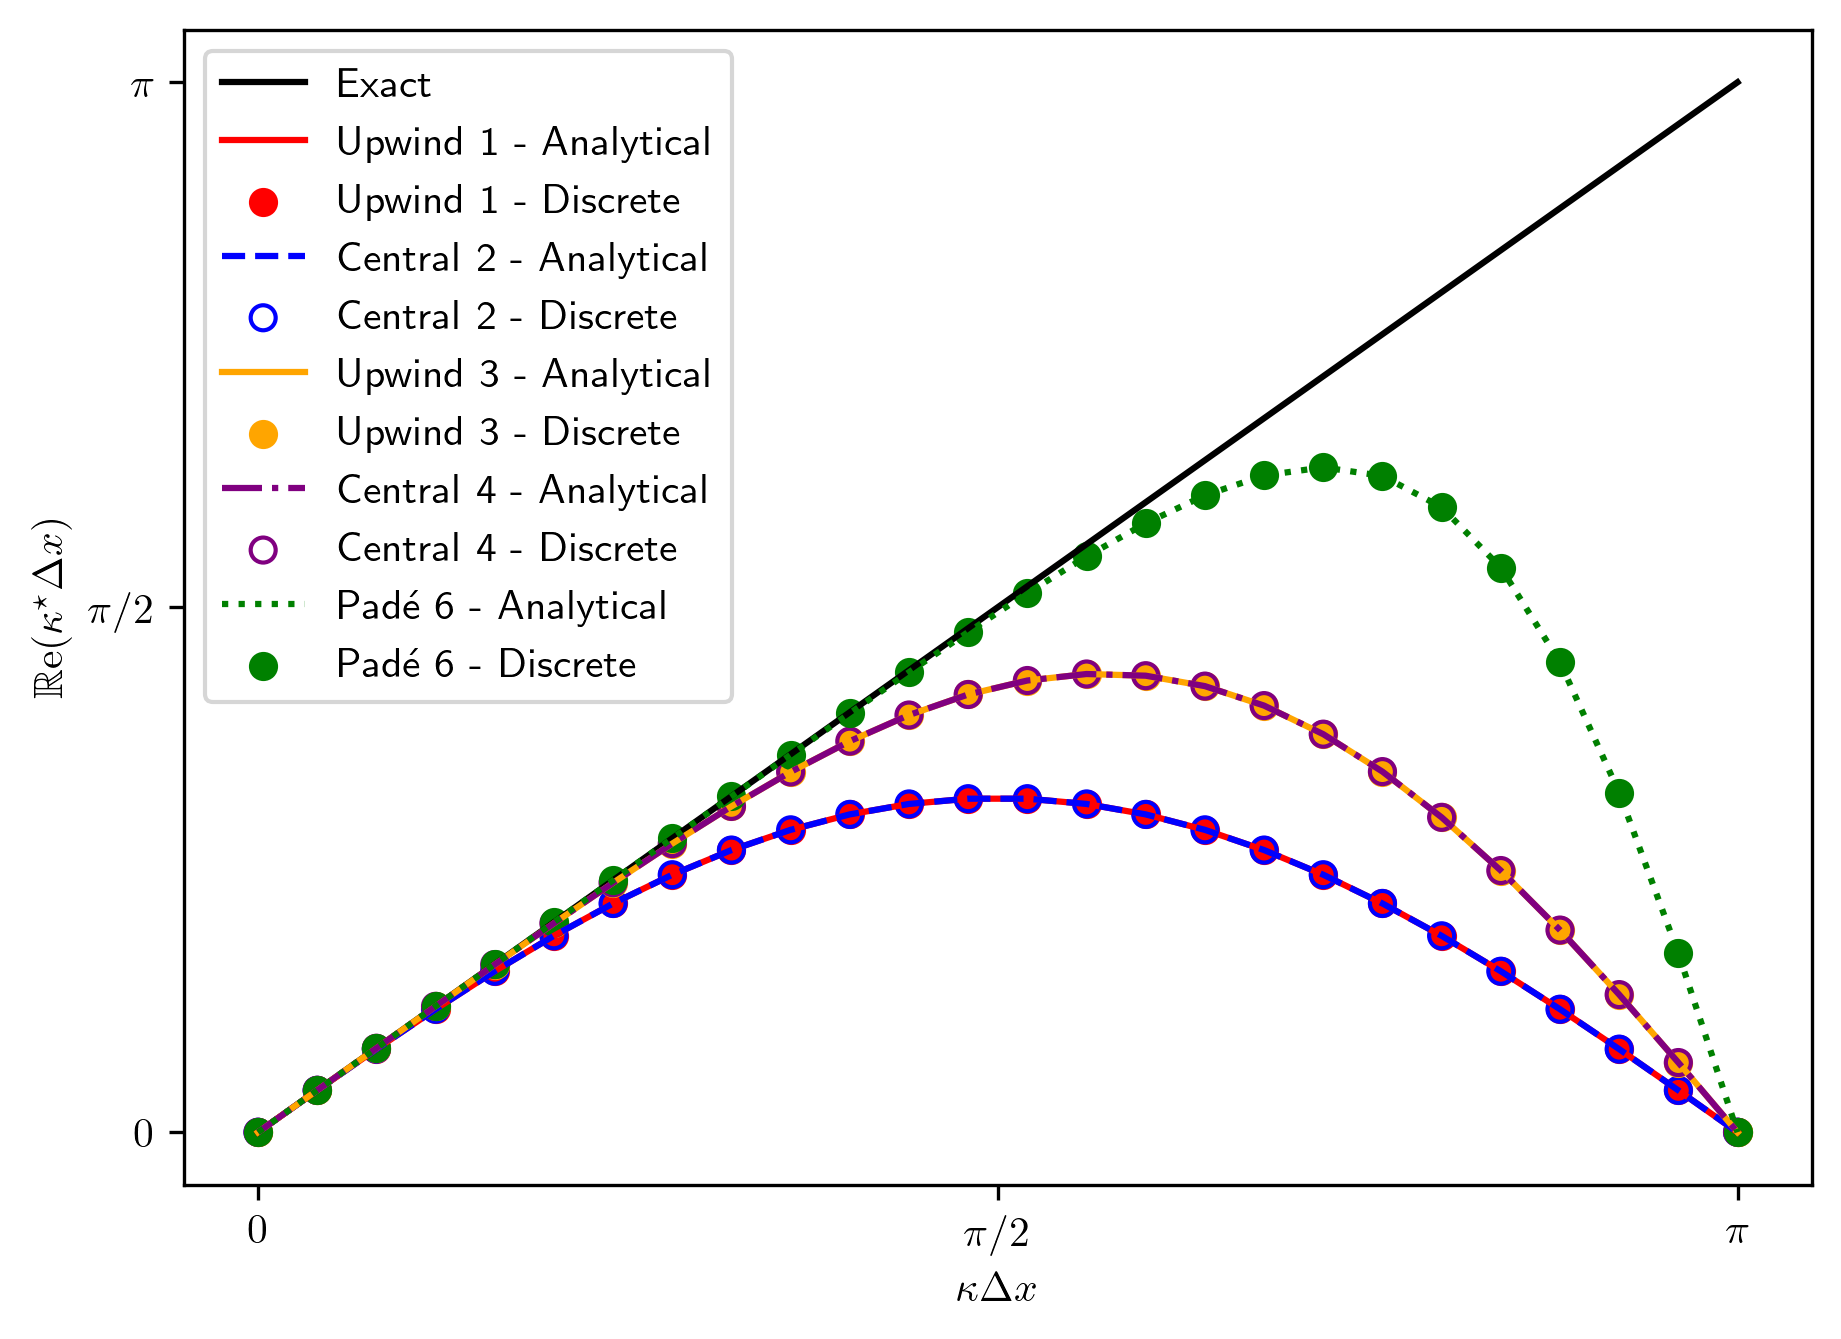

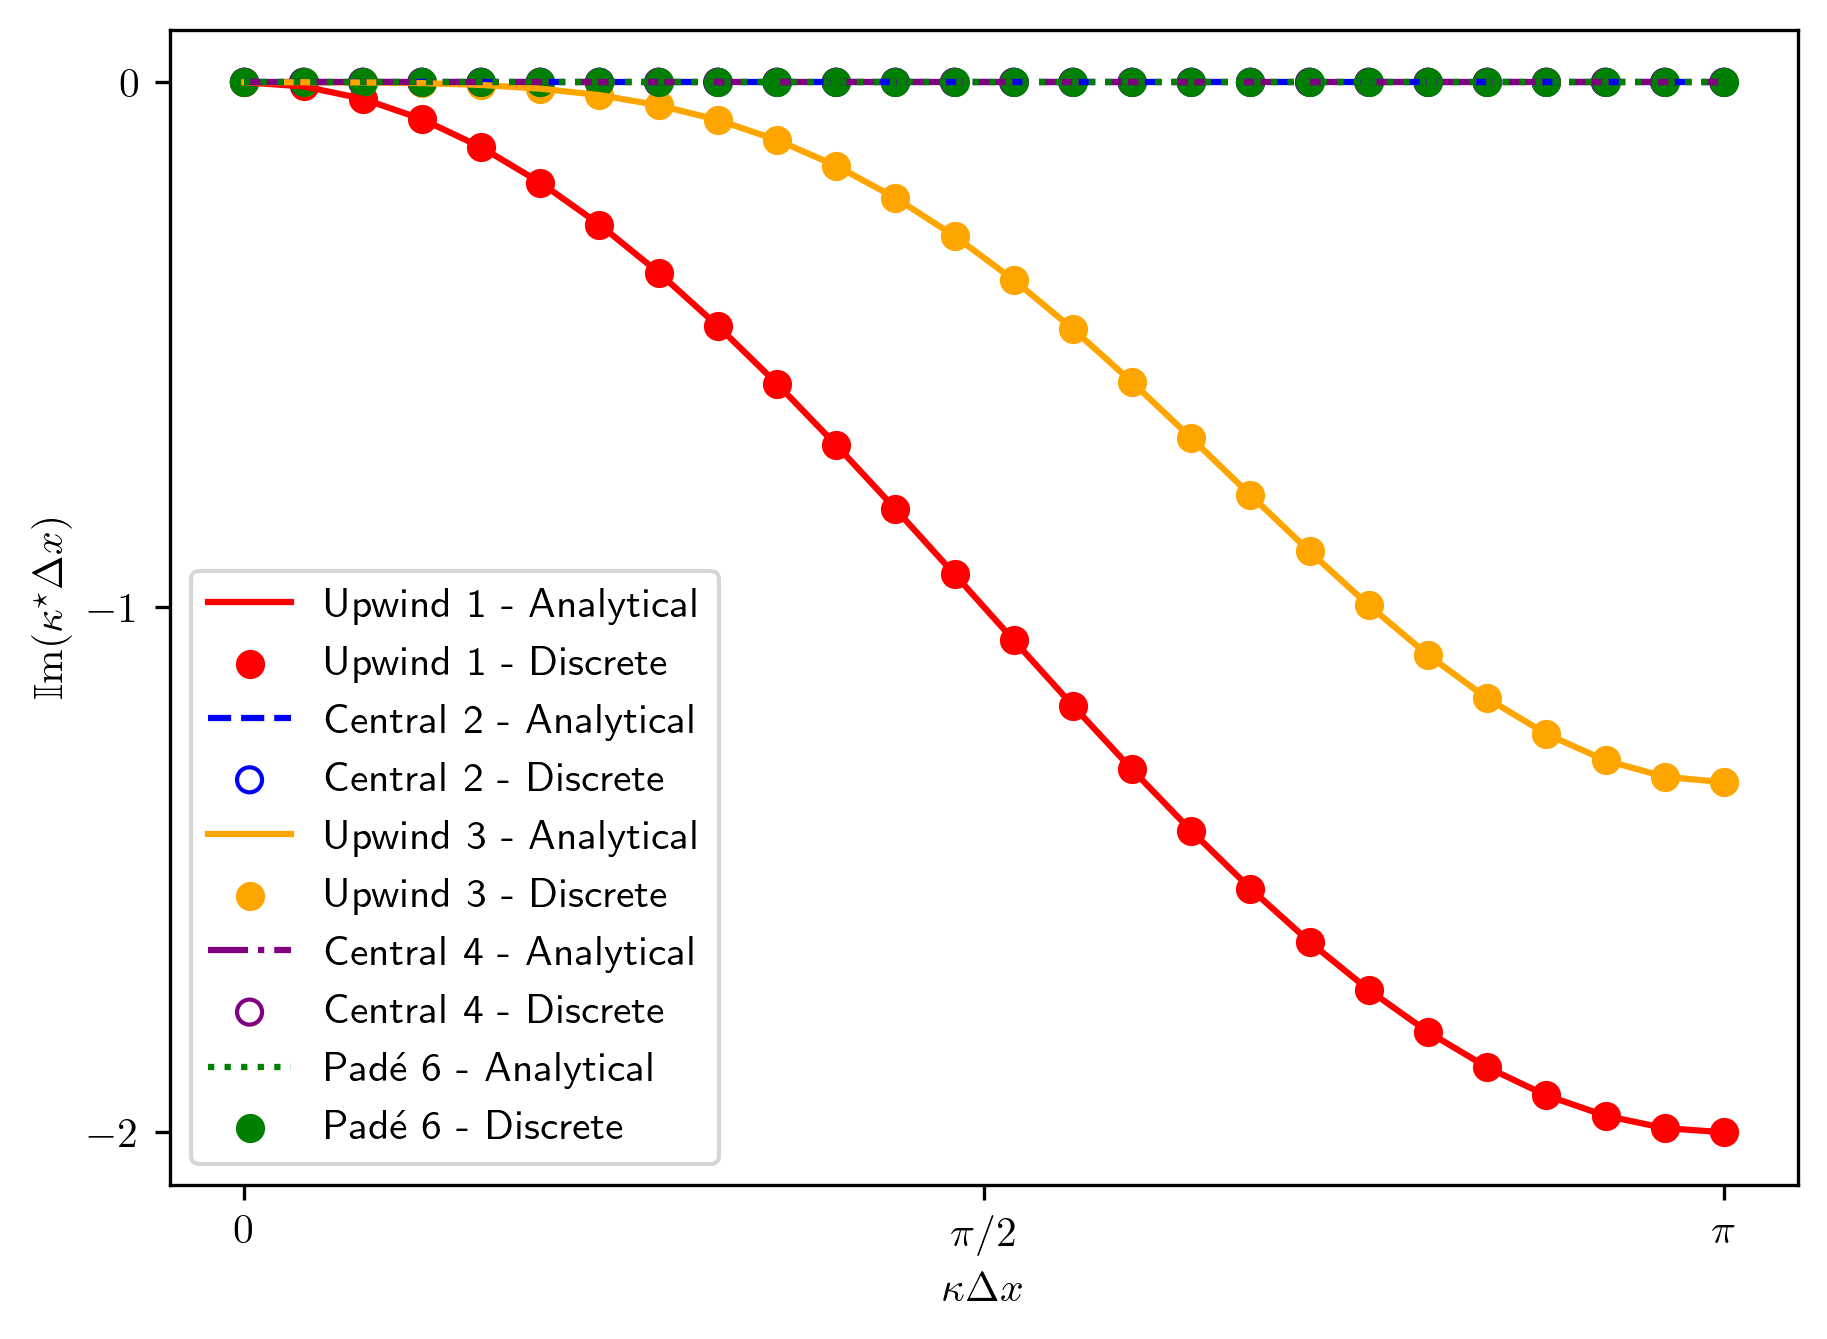

In [74]:
import cmath
# We only plot the first N/2+1 eigenvalues, corresponding to k*dx in [0,pi]
halfNx = int(0.5*Nx+1)
kndx = np.zeros(halfNx)

# Initialize abscissae
for n in range(halfNx):
    kndx[n] = 2*np.pi*n/Nx

# Exact modified wavenumbers
knmoddx_exact_upwind1  = np.sin(kndx) + (np.cos(kndx) - 1) * 1j
knmoddx_exact_central2 = np.sin(kndx)
knmoddx_exact_upwind3  = 4*np.sin(kndx)/3 - np.sin(2*kndx)/6 + (2*np.cos(kndx)/3 - np.cos(2*kndx)/6 - 1/2) * 1j
knmoddx_exact_central4 = 4*np.sin(kndx)/3 - np.sin(2*kndx)/6
knmoddx_exact_pade6    = (2*np.sin(2*kndx) + 56*np.sin(kndx))/(36*(1+2*np.cos(kndx)/3))

# Discrete modified wavenumbers
knmoddx_discrete_upwind1  = np.zeros(halfNx,dtype=complex)
knmoddx_discrete_central2 = np.zeros(halfNx,dtype=complex)
knmoddx_discrete_upwind3  = np.zeros(halfNx,dtype=complex)
knmoddx_discrete_central4 = np.zeros(halfNx,dtype=complex)
knmoddx_discrete_pade6    = np.zeros(halfNx,dtype=complex)

# First rows the matrix A
firstrow_upwind1 = A[0][0]
firstrow_central2 = A[1][0]
firstrow_upwind3 = A[2][0]
firstrow_central4 = A[3][0]
firstrow_pade6 = A[4][0]

# Loop over all schemes to compute discrete eigenvalues
for n in range(halfNx):
    # n-th eigenvector of the circulant matrix
    Vn = np.zeros(Nx,dtype=complex)
    for k in range(Nx):
        Vn[k] = np.exp(2*np.pi*k*n*1j/Nx)
    # The n-th eigenvalue of A is the dot product of the n-th eigenvector with the first row of A (Eq 46 of notes 3)
    knmoddx_discrete_upwind1[n]  = dx*np.dot(firstrow_upwind1, Vn)*1j/a
    knmoddx_discrete_central2[n] = dx*np.dot(firstrow_central2, Vn)*1j/a
    knmoddx_discrete_upwind3[n]  = dx*np.dot(firstrow_upwind3, Vn)*1j/a
    knmoddx_discrete_central4[n] = dx*np.dot(firstrow_central4, Vn)*1j/a
    knmoddx_discrete_pade6[n]    = dx*np.dot(firstrow_pade6, Vn)*1j/a

# Plot real part
fig, ax = plt.subplots(1, 1, figsize=(7, 5)) 
ax.plot(kndx, kndx, 'k', label=r'Exact')
ax.plot(kndx, knmoddx_exact_upwind1.real, color='red', label=r'Upwind 1 - Analytical')
ax.scatter(kndx, knmoddx_discrete_upwind1.real, color='red', label=r'Upwind 1 - Discrete')
ax.plot(kndx, knmoddx_exact_central2.real, color='blue', linestyle='dashed', label=r'Central 2 - Analytical')
ax.scatter(kndx, knmoddx_discrete_central2.real, facecolors='none', edgecolors='blue', label=r'Central 2 - Discrete')
ax.plot(kndx, knmoddx_exact_upwind3.real, color='orange', label=r'Upwind 3 - Analytical')
ax.scatter(kndx, knmoddx_discrete_upwind3.real, color='orange', label=r'Upwind 3 - Discrete')
ax.plot(kndx, knmoddx_exact_central4.real, color='purple', linestyle='dashdot', label=r'Central 4 - Analytical')
ax.scatter(kndx, knmoddx_discrete_central4.real, facecolors='none', edgecolors='purple', label=r'Central 4 - Discrete')
ax.plot(kndx, knmoddx_exact_pade6.real, color='green', linestyle='dotted', label=r'Padé 6 - Analytical')
ax.scatter(kndx, knmoddx_discrete_pade6.real, color='green', label=r'Padé 6 - Discrete')
plt.ylabel(r'$\mathbb{R}\mathrm{e}(\kappa^\star \Delta x)$');plt.xlabel(r'$\kappa\Delta x$')
plt.legend()
tick_labels = [r'$0$',r'$\pi/2$',r'$\pi$']
ticks = [0,np.pi/2,np.pi]
ax.set_xticks(ticks); ax.set_yticks(ticks)
ax.set_xticklabels(tick_labels); ax.set_yticklabels(tick_labels)
plt.savefig('modwavenumber_real.pdf')
plt.show()

# Plot imaginary part
fig, ax = plt.subplots(1, 1, figsize=(7, 5)) 
ax.plot(kndx, knmoddx_exact_upwind1.imag, color='red', label=r'Upwind 1 - Analytical')
ax.scatter(kndx, knmoddx_discrete_upwind1.imag, color='red', label=r'Upwind 1 - Discrete')
ax.plot(kndx, knmoddx_exact_central2.imag, color='blue', linestyle='dashed', label=r'Central 2 - Analytical')
ax.scatter(kndx, knmoddx_discrete_central2.imag, facecolors='none', edgecolors='blue', label=r'Central 2 - Discrete')
ax.plot(kndx, knmoddx_exact_upwind3.imag, color='orange', label=r'Upwind 3 - Analytical')
ax.scatter(kndx, knmoddx_discrete_upwind3.imag, color='orange', label=r'Upwind 3 - Discrete')
ax.plot(kndx, knmoddx_exact_central4.imag, color='purple', linestyle='dashdot', label=r'Central 4 - Analytical')
ax.scatter(kndx, knmoddx_discrete_central4.imag, facecolors='none', edgecolors='purple', label=r'Central 4 - Discrete')
ax.plot(kndx, knmoddx_exact_pade6.imag, color='green', linestyle='dotted', label=r'Padé 6 - Analytical')
ax.scatter(kndx, knmoddx_discrete_pade6.imag, color='green', label=r'Padé 6 - Discrete')
plt.ylabel(r'$\mathbb{I}\mathrm{m}(\kappa^\star \Delta x)$');plt.xlabel(r'$\kappa\Delta x$')
plt.legend()
ytick_labels = [r'$0$',r'$-1$',r'$-2$']
yticks = [0,-1,-2]
ax.set_xticks(ticks); ax.set_yticks(yticks)
ax.set_xticklabels(tick_labels); ax.set_yticklabels(ytick_labels)
plt.savefig('modwavenumber_imag.pdf')
plt.show()